## Bank Marketing Dataset

Today we will look at a bank marketinng dataset. We want to try to find a model that will predict if a client is likely to respond to our marketting campaigns so that we can target our efforts.

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

https://archive.ics.uci.edu/dataset/222/bank+marketing

Input variables:
   #### bank client data:
  1. - age (numeric)
  2. - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar", "self-employed","retired","technician","services")
  3. - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
  4. - education (categorical: "unknown","secondary","primary","tertiary")
  5. - default: has credit in default? (binary: "yes","no")
  6. - balance: average yearly balance, in euros (numeric)
  7. - housing: has housing loan? (binary: "yes","no")
  8. - loan: has personal loan? (binary: "yes","no")
   
   #### related with the last contact of the current campaign:
  9. - contact: contact communication type (categorical: "unknown","telephone","cellular")
  10. - day: last contact day of the month (numeric)
  11. - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
  12. - duration: last contact duration, in seconds (numeric)
   #### other attributes:
  13. - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  14. - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  15. - previous: number of contacts performed before this campaign and for this client (numeric)
  16. - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  #### Output variable (desired target):
  17. - y - has the client subscribed a term deposit? (binary: "yes","no")

  Let's load our libraries.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, CategoricalNB
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc, mean_squared_error, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, RocCurveDisplay, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint



In [2]:
# Load the CSV file into a DataFrame
data = pd.read_csv('8_bank.csv', sep=";")

# Display the first few rows to get an initial understanding
data.head()


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


Use the sum of isnull() to check for null values:

In [3]:
# check for null values
data.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

We are going to need to treat our categorical and continous data seperately. Let's idenfiy these columns with describe, info, then seperate the columns by selecting the data typpe and converting to a list eg.
```
select_dtypes(include='int64').columns.tolist()
```

In [4]:
# check for data types
data.dtypes

age           int64
job          object
marital      object
education    object
default      object
balance       int64
housing      object
loan         object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y            object
dtype: object

In [5]:
# select the categorical and numerical columns
cat_columns = data.select_dtypes(include='object').columns.tolist()
cat_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome',
 'y']

In [6]:
numer_columns = data.select_dtypes(include='int64').columns.tolist()
numer_columns

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

Let's look at our categorical columns in more detail:

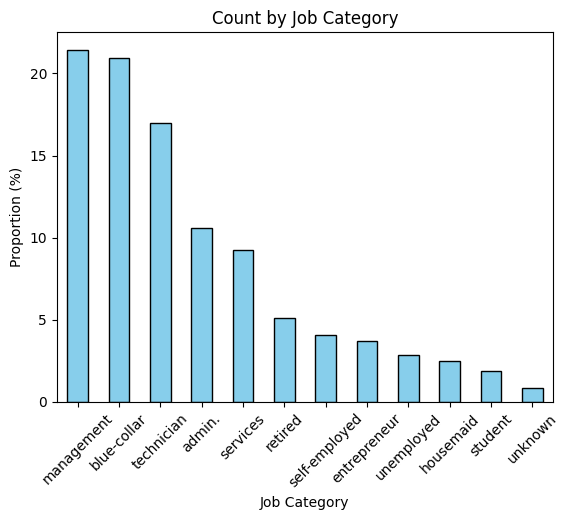

In [7]:
# Count the occurrences of each category
category_counts = data['job'].value_counts(normalize=True) * 100

# Plot the counts
category_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count by Job Category')
plt.xlabel('Job Category')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.show()

If we use onehot encoding we will greatly expand the dimension of our datatset. This will cause more or less of a problem depending on our algorithm. To control this we could have two options:
* **Manuualy group data** Use our domain knowledge to group categories we consider similar. This is likely to be our best option.
* **Automatically group smaller catergories together** Likely to lose more "information" but easier.

Let's see how to use onehot encoder to do the later.

In [8]:
print(data.shape)

(4521, 17)


In [9]:
# Initialize OneHotEncoder with min_frequency
encoder = OneHotEncoder(min_frequency=0.1, handle_unknown='infrequent_if_exist', sparse_output=False, drop = "first")

# Fit and transform only the categorical columns
encoded_array = encoder.fit_transform(data[cat_columns])

# Create a DataFrame for the encoded columns
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_columns))



In [10]:
encoded_df.head()

,job_blue-collar,job_management,job_technician,job_infrequent_sklearn,marital_married,marital_single,education_secondary,education_tertiary,education_infrequent_sklearn,default_infrequent_sklearn,...,loan_yes,contact_unknown,contact_infrequent_sklearn,month_jul,month_jun,month_may,month_infrequent_sklearn,poutcome_unknown,poutcome_infrequent_sklearn,y_yes
0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Plotting this new data is a little tricky, but useful just for us know to understand:

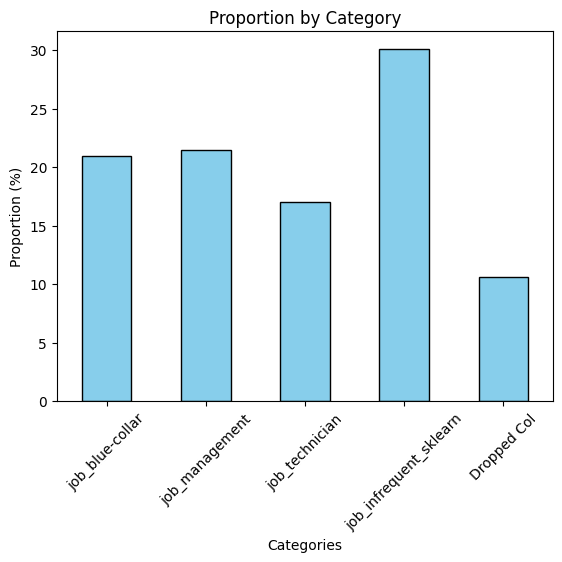

In [11]:
# Function to get one-hot encoded columns for a specific label
def get_encoded_columns(label, encoded_columns):
    return [col for col in encoded_columns if col.startswith(f"{label}_")]

# Automatically detect columns for 'job'
job_encoded_columns = get_encoded_columns('job', encoded_df.columns)

category_counts = encoded_df[job_encoded_columns].sum()

# Normalize to get proportions (Optional)
category_proportions = (category_counts / len(encoded_df)) * 100
category_proportions["Dropped Col"] = (100 - category_proportions.sum())

# Plot the proportions
category_proportions.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Proportion by Category')
plt.xlabel('Categories')
plt.ylabel('Proportion (%)')
plt.xticks(rotation=45)
plt.show()

**Important** In the previous code note the use of what to do with new categories if they come along:
* By default these might get classified as the dropped category.
* Here we are putting them in with infrequent.

Let's combine our data back together:

In [12]:
# Concatenate the original DataFrame with the encoded columns
final_df = pd.concat([data[numer_columns], encoded_df], axis=1)
print(final_df.shape)
print(final_df.columns)

(4521, 28)
Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous',
       'job_blue-collar', 'job_management', 'job_technician',
       'job_infrequent_sklearn', 'marital_married', 'marital_single',
       'education_secondary', 'education_tertiary',
       'education_infrequent_sklearn', 'default_infrequent_sklearn',
       'housing_yes', 'loan_yes', 'contact_unknown',
       'contact_infrequent_sklearn', 'month_jul', 'month_jun', 'month_may',
       'month_infrequent_sklearn', 'poutcome_unknown',
       'poutcome_infrequent_sklearn', 'y_yes'],
      dtype='object')


Setup our target variable (remember to not include it in the training data) and split our data. Split all of the data together, both numerical and categorical.


In [13]:
y = final_df["y_yes"]
X = final_df.drop("y_yes", axis=1)

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

We are going to work with algorithms that prefer scaled data, let's apply that now:

In [15]:
scaler = StandardScaler()
scaler.fit(X_train[numer_columns])
X_train[numer_columns] = scaler.transform(X_train[numer_columns])
X_test[numer_columns] = scaler.transform(X_test[numer_columns])


We are going to apply cross validation. As a benchmark let's use KNN without validation. I'm going to create a nice function to do our error metric reporting for us:

In [16]:
def classification_metrics(y_true, y_pred, y_proba=None):
    """
    Report typical classification metrics and visualize confusion matrix and ROC curve.

    Parameters:
    - y_true: Ground truth (true labels).
    - y_pred: Predicted labels.
    - y_proba: Predicted probabilities for the positive class (required for ROC and AUC).

    Returns:
    None (prints and visualizes metrics).
    """
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)

    # Display Confusion Matrix
    ConfusionMatrixDisplay(conf_matrix).plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

    # Classification Report (Precision, Recall, F1-Score)
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))


    # ROC and AUC
    if y_proba is not None:
        auc = roc_auc_score(y_true, y_proba)

        # Plot ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_proba)
        RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc).plot()
        plt.title("ROC Curve")
        plt.show()
    else:
        print("ROC and AUC are not available because `y_proba` is not provided.")



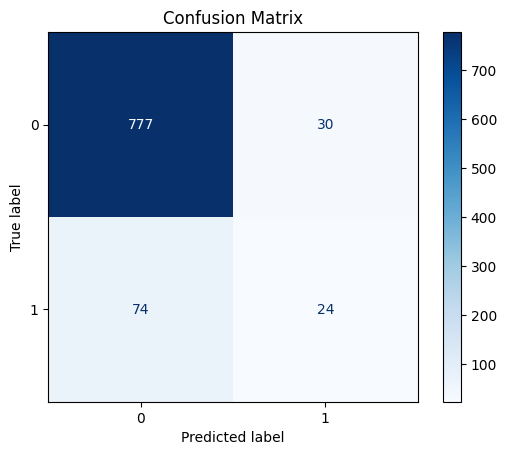


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.96      0.94       807
         1.0       0.44      0.24      0.32        98

    accuracy                           0.89       905
   macro avg       0.68      0.60      0.63       905
weighted avg       0.86      0.89      0.87       905



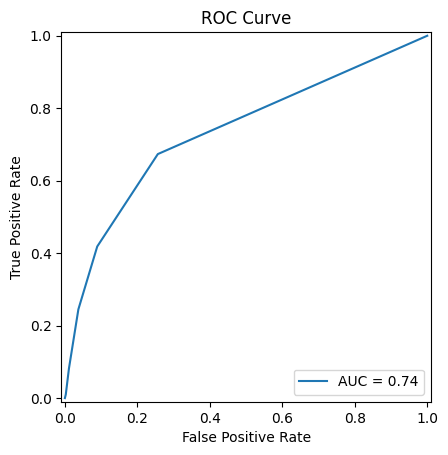

In [17]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
y_proba = knn.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

Let's make use of our cross validation to do hyperparaneter tuning to improve our classifier. We will apply a grid search approach.

First we will need to setup a dictionary to define the parameters to test:

```
param_grid = {
    'paramter name 1': [list of values 1],      
    'paramter name 2': [list of values 2],  
}
```

Check the parameters for KNN, obviously we want to set number of paramaters, but maybe distance is interesting?

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier


In [19]:
# Define the parameter grid for hyperparameter tuning

knn_params = {
    'n_neighbors': [1,2,3,4,5,6,7,8,9,10,25,50,75,100],      
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}


Then we will need to setup the grid search.

https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.GridSearchCV.html

It is good to review the scoring options as well, maybe f1 is a nice option:

https://scikit-learn.org/dev/modules/model_evaluation.html#scoring-parameter

In [22]:
# Define the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=knn, param_grid=knn_params, cv=5, scoring='f1', n_jobs=-1)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan', ...], 'n_neighbors': [1, 2, ...], 'weights': ['uniform', 'distance']}"
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,1


Let's check what were the best parameters and the best score:

In [23]:
# Print the best parameters and the corresponding score
print("Best Parameters:", grid_search.best_params_ )
print("Best Cross-Validated Score:", grid_search.best_score_ )

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best Cross-Validated Score: 0.36789925627802245


Finally, we don't need to refit the model but can use the GridSearchCV directly by accessing the `.best_estimator_`.

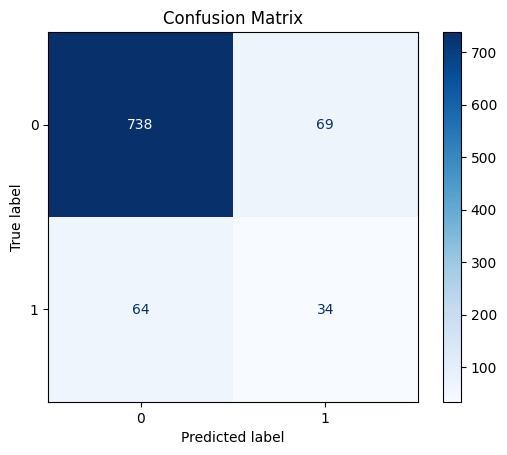


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.91      0.92       807
         1.0       0.33      0.35      0.34        98

    accuracy                           0.85       905
   macro avg       0.63      0.63      0.63       905
weighted avg       0.86      0.85      0.85       905



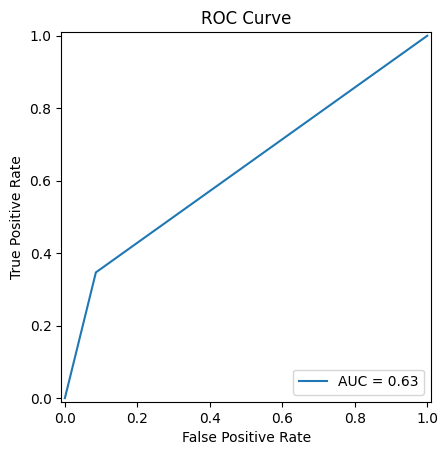

1


In [25]:
# Evaluate the best model on the test data
best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test)
y_proba_best = best_knn.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred_best, y_proba_best)
print(best_knn.n_neighbors)


Let's check the metrics:

It looks like higher k is better, maybe we should expand our search.

This time let's do a random search. Now we need to provide distributions for the data:

https://scikit-learn.org/dev/modules/generated/sklearn.model_selection.RandomizedSearchCV.html

In [27]:
# Define the KNN classifier
knn = KNeighborsClassifier()

# Define the parameter distributions for random search
param_distributions = {
    'n_neighbors': randint(1, 1000),      # Randomly sample number of neighbors between 1 and 1000
    'metric': ['euclidean', 'manhattan'],  # Distance metrics
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=knn,
    param_distributions=param_distributions,
    n_iter=100,  # Number of random parameter combinations to test
    cv=5,       # 5-fold cross-validation
    scoring='recall',
    random_state=42,
    n_jobs=-1   # Use all available CPU cores
)

In [28]:
# Fit RandomizedSearchCV on training data
random_search.fit(X_train, y_train)

# Print the best parameters and the corresponding score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validated Accuracy:", random_search.best_score_)

Best Parameters: {'metric': 'euclidean', 'n_neighbors': 15}
Best Cross-Validated Accuracy: 0.15369747899159664


Let's take a look at all our metrics:

15


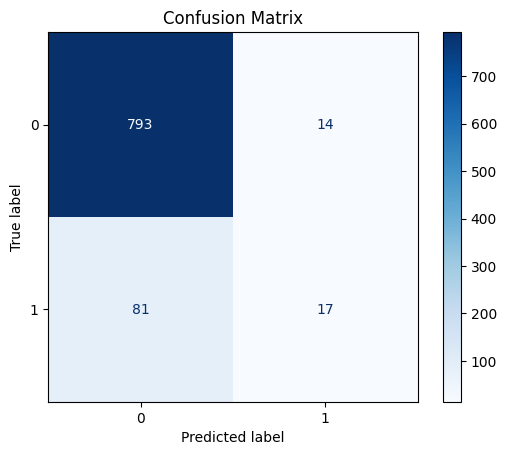


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.98      0.94       807
         1.0       0.55      0.17      0.26        98

    accuracy                           0.90       905
   macro avg       0.73      0.58      0.60       905
weighted avg       0.87      0.90      0.87       905



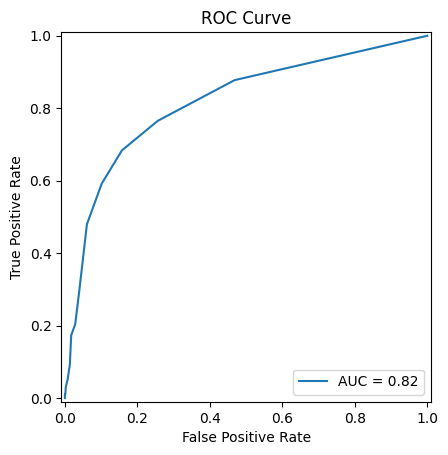

In [29]:
# Evaluate the best model on the test data
best_knn = random_search.best_estimator_
print(best_knn.n_neighbors)
y_pred = best_knn.predict(X_test)
y_proba = best_knn.predict_proba(X_test)[:, 1]
classification_metrics(y_test, y_pred, y_proba)

#### Exercise 1

Use everything you have learned to apply the LDA and QDA classifiers to this dataset. I've provided some hints for you on hyperparaters you may wish to consider:

##### Linear Discriminant Analysis (LDA)

https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html

* Optimization algorithm
* Shrinkage

#### Quadratic Discriminant Analysis (QDA)
https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html

Check the documentation to test the following hyper parameters in cross validation:
* reg_param:





In [34]:
# Define the LDA classifier
lda = LinearDiscriminantAnalysis()

# Define the parameter distributions for random search
lda_params = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'shrinkage': [None, 'auto'] + list(np.linspace(0, 1, 10))  # None, 'auto', and values between 0 and 1
}

# Initialize RandomizedSearchCV
lda_search = RandomizedSearchCV(
    estimator=lda,
    param_distributions=lda_params,
    cv=5,       # 5-fold cross-validation
    scoring='f1',
    n_jobs=-1,   # Use all available CPU cores,
)

In [35]:
# run the lda search
lda_search.fit(X_train, y_train)

c:\my-git\DataScience-novaIMS\MachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
20 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "c:\my-git\DataScience-novaIMS\MachineLearning\.venv\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\my-git\DataScience-novaIMS\MachineLearning\.venv\Lib\site-packages\sklearn\base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\my-git\DataScience-novaIMS\

,estimator,LinearDiscriminantAnalysis()
,param_distributions,"{'shrinkage': [None, 'auto', ...], 'solver': ['svd', 'lsqr', ...]}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


Best Parameters: {'solver': 'eigen', 'shrinkage': 'auto'}
Best Cross-Validated Accuracy: 0.4910549801076117
0.4910549801076117


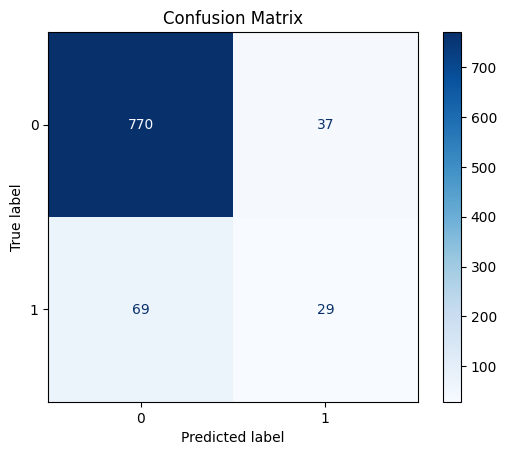


Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      0.95      0.94       807
         1.0       0.44      0.30      0.35        98

    accuracy                           0.88       905
   macro avg       0.68      0.63      0.64       905
weighted avg       0.87      0.88      0.87       905



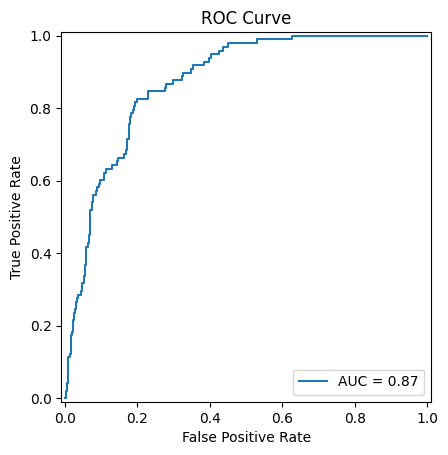

In [38]:
# Print the best parameters and the corresponding score
print("Best Parameters:", lda_search.best_params_)
print("Best Cross-Validated Accuracy:", lda_search.best_score_)
# Evaluate the best model on the test data
best_lda = lda_search.best_estimator_
print(lda_search.best_score_)
classification_metrics(y_test, best_lda.predict(X_test), best_lda.predict_proba(X_test)[:, 1])

In [ ]:
# Define the LDA classifier
qda = QuadraticDiscriminantAnalysis()

# Define the parameter distributions for random search
qda_params = {
    #'solver': ['priors', 'reg_param', 'store_covariance', 'tol'],
    'reg_param': np.linspace(0.0, 1.0, 20)
}

# Initialize RandomizedSearchCV
qda_search = RandomizedSearchCV(
    estimator=qda,
    param_distributions=qda_params,
    cv=5,       # 5-fold cross-validation
    scoring='f1',
    n_jobs=-1,   # Use all available CPU cores,
)

In [46]:
#run the qda search
qda_search.fit(X_train, y_train)

,estimator,QuadraticDisc...nantAnalysis()
,param_distributions,"{'reg_param': [0.0, 0.1, ...]}"
,n_iter,10
,scoring,'f1'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


Best Parameters: {'reg_param': 0.1}
Best Cross-Validated Accuracy: 0.48465224447293453
0.48465224447293453


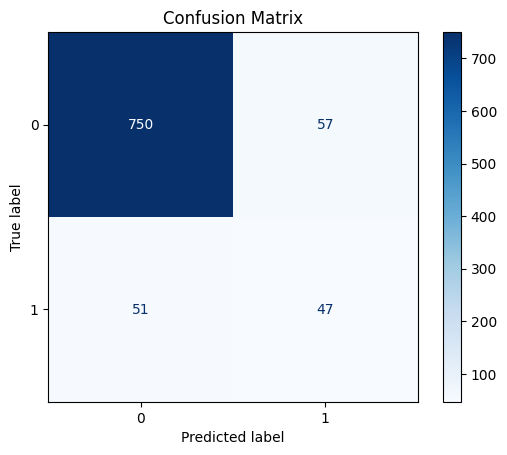


Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       807
         1.0       0.45      0.48      0.47        98

    accuracy                           0.88       905
   macro avg       0.69      0.70      0.70       905
weighted avg       0.88      0.88      0.88       905



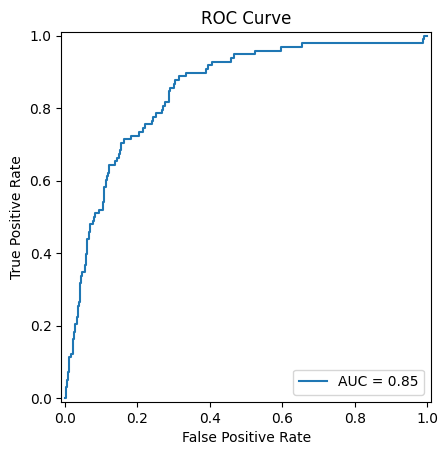

In [47]:
# Print the best parameters and the corresponding score
print("Best Parameters:", qda_search.best_params_)
print("Best Cross-Validated Accuracy:", qda_search.best_score_)
# Evaluate the best model on the test data
best_qda = qda_search.best_estimator_
print(qda_search.best_score_)
classification_metrics(y_test, best_qda.predict(X_test), best_qda.predict_proba(X_test)[:, 1])

#### Exercise 2

Use everything you have learned to fit and compare the models we have seen to find the best classifier on this dataset. I've provided some hints for you on hyperparaters you may wish to consider:

##### KNN
K-Nearest Neighbors (KNN)
* n_neighbors: Key parameter to tune as it controls the model's complexity (smaller values = more complex). The number of neighbors to use.
  *	Typical range: 1 to 30.
* weights: How to weight the neighbors' contributions to the classification:
  *	'uniform': All neighbors have equal weight.
  *	'distance': Closer neighbors have greater weight.
* metric: Tuning this can significantly affect performance depending on the dataset. Distance metric for finding neighbors:
  *	'euclidean', 'manhattan', 'minkowski', or a custom distance.


##### Logistic Regression
* penalty: The type of regularization:
  * 'l1': Lasso regularization.
  * 'l2': Ridge regularization.
  * 'elasticnet': Combination of L1 and L2 (only supported by saga solver).
  * 'none': No regularization.
* C: Inverse of regularization strength (smaller values = stronger regularization).
  * Typical range: 0.001 to 100.
* solver: Optimization algorithm used for training:
  * 'lbfgs': Handles L2 regularization, efficient for small datasets.
  * 'liblinear': Handles L1 and L2, good for small datasets.
  * 'saga': Supports L1, L2, and elastic-net regularization, good for large datasets.
* class_weight: Adjust weights for imbalanced classes:
  * 'balanced': Automatically adjusts weights inversely proportional to class frequencies.
  * Custom dictionary: Specify class weights manually.


##### Gaussian Naive Bayes
* var_smoothing: Portion of the largest variance of features added to variances for stability. Useful when features have very small variances.
  * Typical range: 1e-12 to 1e-9.

##### Multinomial Naive Bayes
* alpha: Additive smoothing parameter to avoid zero probabilities.
  *	Typical range: 0.1 to 1.0.
* fit_prior: Whether to learn class priors from the data or use uniform priors:
  * True: Learns priors from data.
  * False: Assumes uniform class priors.